In [42]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [40]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
        "PlantVillage",
        shuffle=True,
        image_size = (IMAGE_SIZE,IMAGE_SIZE),
        batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
classes = dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)    #Each batch is of 32 images, 68 * 32 = 2152, so 68 batches are created and 68 is the size of our dataset

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 1 0 1 2 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0]


In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[163. 156. 164.]
  [170. 163. 171.]
  [168. 161. 169.]
  ...
  [162. 158. 172.]
  [160. 156. 170.]
  [161. 157. 171.]]

 [[161. 154. 162.]
  [167. 160. 168.]
  [166. 159. 167.]
  ...
  [166. 162. 176.]
  [163. 159. 173.]
  [163. 159. 173.]]

 [[161. 154. 162.]
  [166. 159. 167.]
  [164. 157. 165.]
  ...
  [167. 163. 177.]
  [166. 162. 176.]
  [166. 162. 176.]]

 ...

 [[103.  91. 101.]
  [108.  96. 106.]
  [114. 102. 112.]
  ...
  [107.  96. 110.]
  [106.  95. 109.]
  [108.  97. 111.]]

 [[103.  91. 101.]
  [109.  97. 107.]
  [110.  98. 108.]
  ...
  [112. 101. 115.]
  [108.  97. 111.]
  [109.  98. 112.]]

 [[101.  89.  99.]
  [106.  94. 104.]
  [104.  92. 102.]
  ...
  [108.  97. 111.]
  [107.  96. 110.]
  [110.  99. 113.]]]


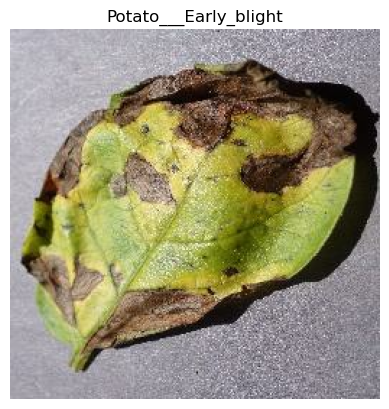

In [8]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(classes[label_batch[0]])
    plt.axis("off")

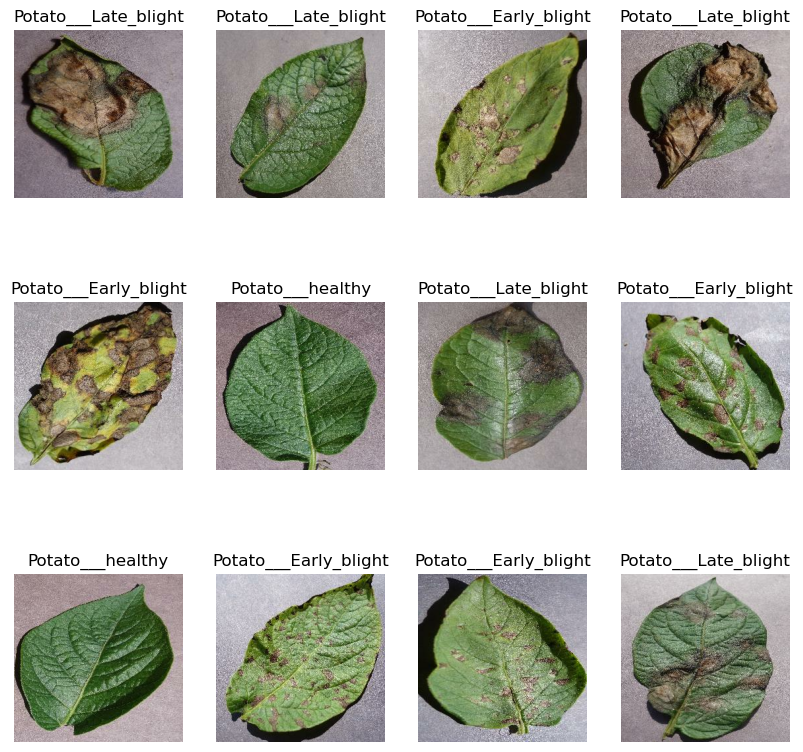

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes[label_batch[i]])
        plt.axis("off")

### training set = 80%, validation set = 10%, test set = 10%

In [10]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
rest_ds = dataset.skip(54)
len(rest_ds)

14

In [13]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds = rest_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = rest_ds.skip(6)
len(test_ds)

8

### Splitting Data as Train, Validation, Test Dataset

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Defining Model Architecture

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Training CNN Model

In [30]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
54/54 [==============================] - 101s 2s/step - loss: 0.7164 - accuracy: 0.6782 - val_loss: 0.5463 - val_accuracy: 0.7396
Epoch 2/30
54/54 [==============================] - 90s 2s/step - loss: 0.3881 - accuracy: 0.8264 - val_loss: 0.4578 - val_accuracy: 0.7969
Epoch 3/30
54/54 [==============================] - 90s 2s/step - loss: 0.3092 - accuracy: 0.8929 - val_loss: 0.3089 - val_accuracy: 0.8854
Epoch 4/30
54/54 [==============================] - 90s 2s/step - loss: 0.2182 - accuracy: 0.9057 - val_loss: 0.1218 - val_accuracy: 0.9740
Epoch 5/30
54/54 [==============================] - 92s 2s/step - loss: 0.1201 - accuracy: 0.9543 - val_loss: 0.1096 - val_accuracy: 0.9688
Epoch 6/30
54/54 [==============================] - 90s 2s/step - loss: 0.0770 - accuracy: 0.9774 - val_loss: 0.0661 - val_accuracy: 0.9740
Epoch 7/30
54/54 [==============================] - 90s 2s/step - loss: 0.0776 - accuracy: 0.9693 - val_loss: 0.0669 - val_accuracy: 0.9740
Epoch 8/30
54/54 [=

In [31]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 7s 387ms/step - loss: 0.0024 - accuracy: 1.0000


In [33]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

### Plotting Accuracy And Loss Graphs

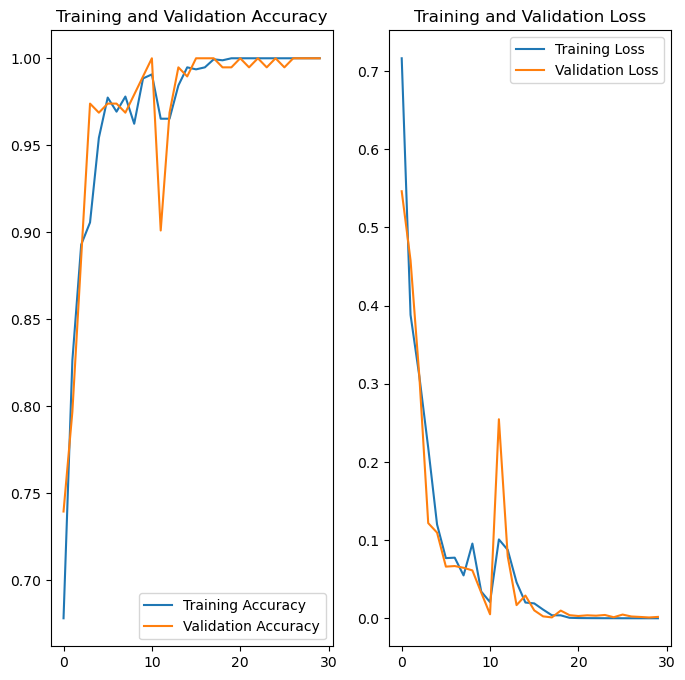

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predicting Diseases

Predicting First Image.
Actual Label: Potato___Late_blight
1/1 [==============================] - 0s 417ms/step
Predicted Label: Potato___Late_blight


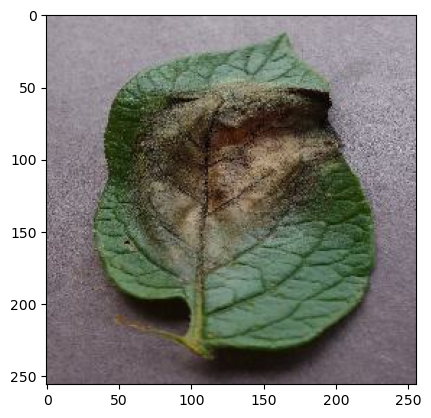

In [51]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("Predicting First Image.")
    plt.imshow(first_image)
    print("Actual Label:",classes[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label:",classes[np.argmax(batch_prediction[0])])

### Function for making predictions

In [54]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Running our Function to make Predictions

1/1 [==============================] - 0s 35ms/step


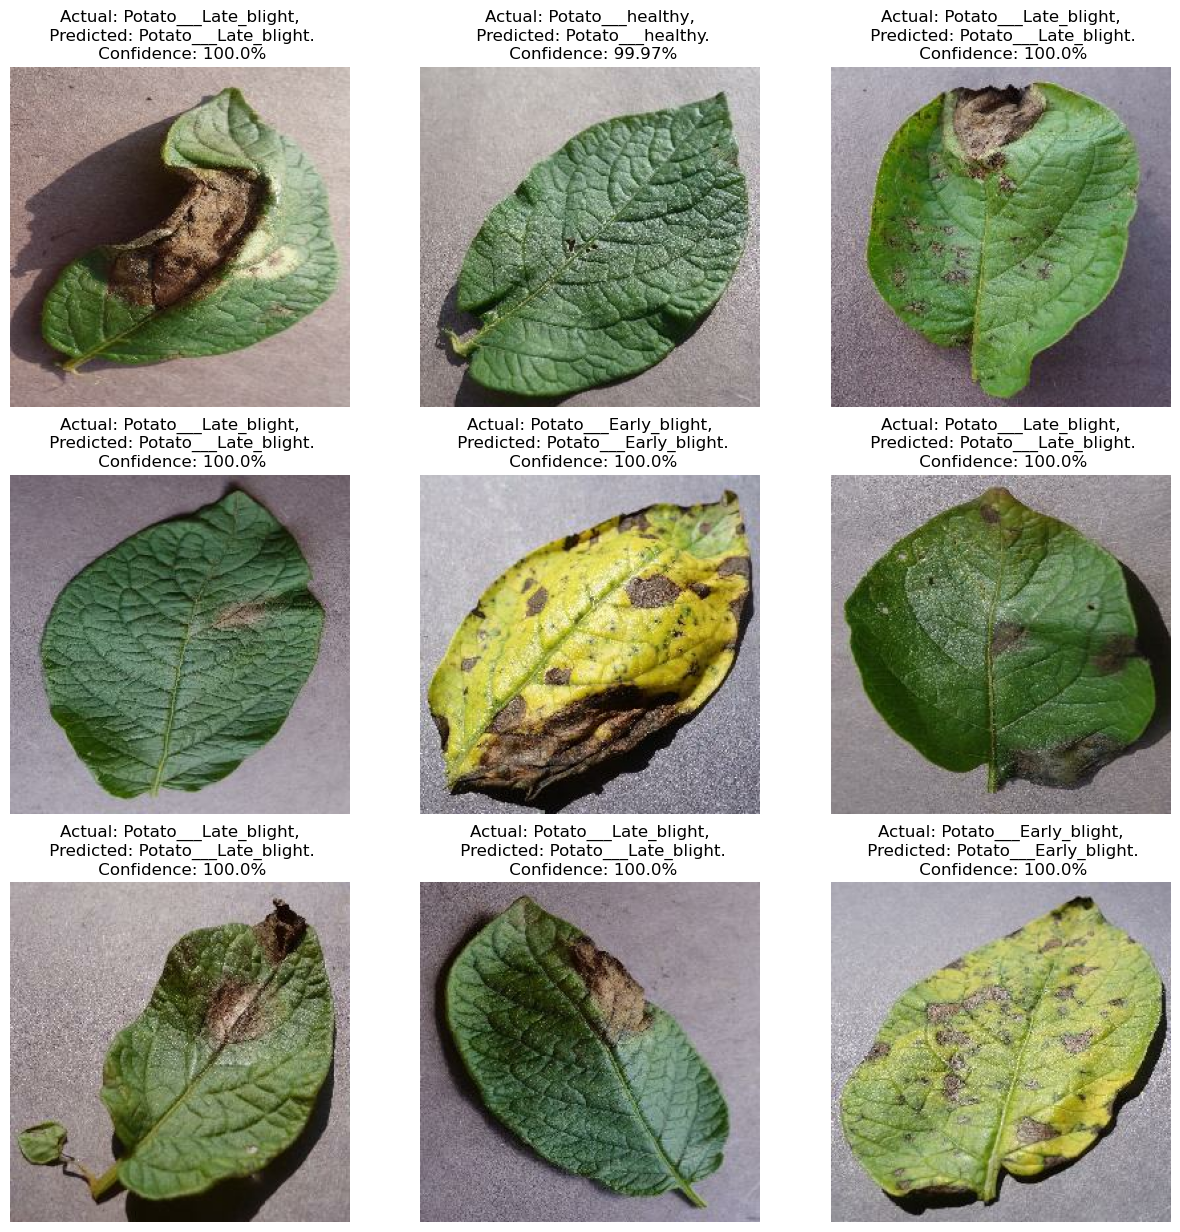

In [55]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [57]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [58]:
# import os
# model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
# model.save(f"../models/{model_version}")